# A2: Image classification in the brower

In this assignment, you will gain real-world experience with image classification on small datasets - a common scenario in practice. There are three parts.

1. First, you will train a model on a small existing dataset.

2. Next,  you will collect a small dataset yourself. Of course, in practice there often isn’t  a dataset available for tasks you care about, so it’s valuable to get a feel for this process. You will train a small model from scratch, then use data augmentation to improve accuracy.

3. Finally, you will deploy your model from part two in a webpage using TensorFlow.js. A user will be able to upload a photo, and your model will classify it. 

## Instructions

Please complete this notebook by searching for **"TODO"**.

## Submission instructions

Please submit this assignment on CourseWorks by uploading a Jupyter notebook that includes saved output. If you are working in Colab, you can prepare your notebook for submission by ensuring that runs end-to-end, then saving and downloading it:

1. ```Runtime -> Restart and run all```
1. ```File -> Save```
1. ```File -> Download.ipynb```

Note: you will need to include a URL to your webpage for part 3, see the final TODO at the bottom of this notebook.

## Setup instructions
1. If you are running this notebook in Colab, make sure a GPU is enabled (```Edit -> Notebook settings -> Hardware accelerator```).

2. Create a GitHub Pages repo by following the instructions at https://pages.github.com/. You can use this to upload your webpage after getting it running locally.

In [0]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


## 1a) Flowers

In this part of the assignment, you will train a model on a small existing dataset (flowers).

In [0]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

### Download the flowers dataset

In [0]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 1s 0us/step
/root/.keras/datasets/flower_photos


### Write an input pipeline from scratch
There are several ways to load images in TensorFlow. Later in this assignment, you'll use the [Keras preprocessing utilities](https://keras.io/preprocessing/image/). For starters, though, you'll see how-to write your own using ```tf.data```, based on this [tutorial](https://www.tensorflow.org/beta/tutorials/load_data/images). This is valuable to do once (just so you can see how the nuts and bolts work) before using the higher level utils. This code is written for you as an example. Follow along and try to understand each piece.


In [0]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count


3670

In [0]:
all_image_paths[:5]

['/root/.keras/datasets/flower_photos/dandelion/7148085703_b9e8bcd6ca_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/10919961_0af657c4e8.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/2478018280_1be353ca8c_m.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/18972803569_1a0634f398_m.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/4573204407_babff0dce4_n.jpg']

### Get to know your data

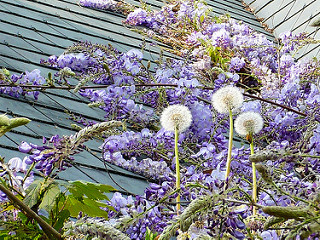

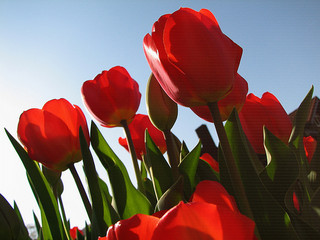

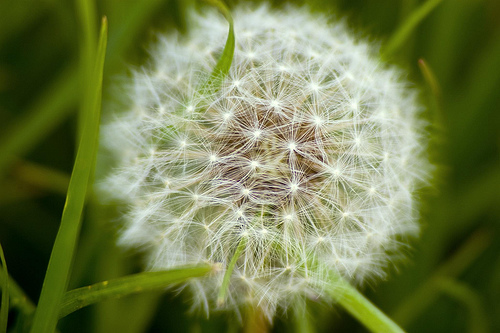

In [0]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

### Classes are given by directory names

In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [0]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [0]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [1, 1, 1, 3, 1, 4, 3, 0, 0, 1]


### Create a train/test split

In [0]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)   

### Display a few images and their labels

dandelion


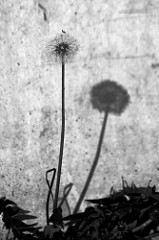


roses


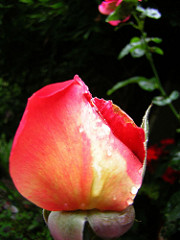


tulips


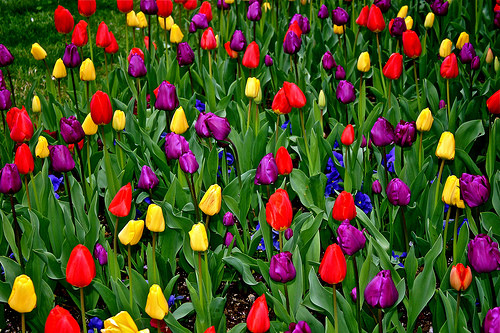

In [0]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

### Begin using TensorFlow ops to read and decode the images

In [0]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x...


In [0]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(333, 500, 3)
<dtype: 'uint8'>


In [0]:
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.022255475
1.0


### Wrap those in a function
Tip: pay careful attention to the preprocessing. When you deploy models in the browser, you will need to ensure that images are preprocessed identically in JavaScript as they are in Python.

In [0]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

In [0]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

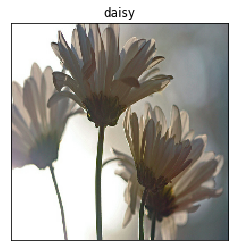

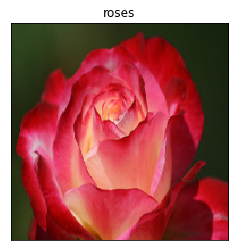

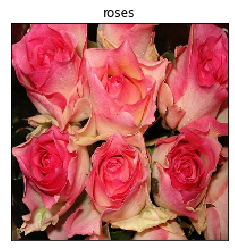

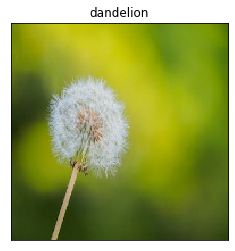

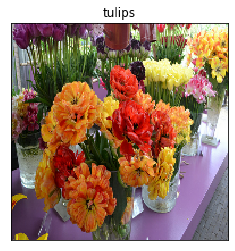

In [0]:
for i in range(0,5):
  img_path = train_paths[i]
  img = load_and_preprocess_image(img_path)
  label = label_names[train_labels[i]]
  plt.figure()
  show(img, label)
plt.show()

### Build an input pipeline to return images and labels
I realize this is complicated. The problem we're trying to solve using tf.data is performance (we want our preprocessing to run in C, but to write our code in Python). There are a bunch of advanced tricks you can do with tf.data as well (e.g. prefetching images to the GPU).

Note: although your *peak* performance can be higher, it's also very easy to make mistakes and end up with code that's super slow. Always benchmark your input pipelines before using them (shown in a bit). 

In [0]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/3386988684_bc5a66005e.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/1562198683_8cd8cb5876_n.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/3654988152_b11178bbcb.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/17388674711_6dca8a2e8b_n.jpg', shape=(), dtype=string)


In [0]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [0]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

daisy
roses
roses
dandelion


In [0]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [0]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) daisy
(192, 192, 3) roses


### Batch and shuffle
Why do we need to specify a shuffle_size parameter? tf.data works with streams (it doesn't know their length). To shuffle items, we maintain an in-memory buffer of this size.

In [0]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


At this point, you could use the dataset above to train a model with ```model.fit(ds)``` but first, let's improve performance. As written, the dataset will load each image off disk, one at a time (super slow). Instead, we want to cache them in memory.

### Improve performance

In [0]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching
This is a small dataset, so let's keep it in memory. The first time we iterate over this dataset, images will be loaded off disk, then cached. The first iteration will be quite slow, and subsequent ones will be faster. Let's show that. 

In [0]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [0]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
19.34 Batches/s
618.75 Images/s
Total time: 4.4476776123046875s


Now that the cache is built, iteration will be much faster.

In [0]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
223.01 Batches/s
7136.41 Images/s
Total time: 0.38562822341918945s


### How-to use on-disk caching

If the dataset did not fit into memory, you could use a cache file on disk, like this:

```
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.shuffle(buffer_size=BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
```

This can be useful to perform expensive preprocessing only once, and/or to improve file I/O (TF saves the cache file in an efficient format - it can be faster to read one large file than a bunch of small ones). For now, we'll keep it in memory.

In [0]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

### Finally, we have a fast pipeline ready to go, written from scratch
Now, let's define a model.

## 1b) Create a simple CNN
This is our baseline model, it will not be very accurate. You'll improve it below.

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

### Tip: pay attention to the size of the model
Later, when you export a model to run in the webpage, you will want a small one (in terms of the number of parameters) that downloads quickly. Notice how much more efficient convolutional layers are than the dense layers (ask yourself,why?)

### Tip: pay attention to exactly how your images are preprocessed
Later, when you run your model in a browser, you'll need to preprocess images in JavaScript in exactly the same way.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 144400)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 722005    
Total params: 722,453
Trainable params: 722,453
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# I realize we're not using a separate test set, that's fine
# for this assignment
model.fit(train_ds, validation_data=test_ds, epochs=5)

Train for 86 steps, validate for 29 steps
Epoch 1/5
86/86 [==============================] - 12s 144ms/step - loss: 2.6919 - accuracy: 0.4346 - val_loss: 1.0840 - val_accuracy: 0.5610
Epoch 2/5
86/86 [==============================] - 2s 27ms/step - loss: 0.9531 - accuracy: 0.6414 - val_loss: 1.1337 - val_accuracy: 0.5359
Epoch 3/5
86/86 [==============================] - 2s 27ms/step - loss: 0.6913 - accuracy: 0.7631 - val_loss: 1.0316 - val_accuracy: 0.6046
Epoch 4/5
86/86 [==============================] - 2s 27ms/step - loss: 0.4460 - accuracy: 0.8735 - val_loss: 1.2243 - val_accuracy: 0.5490
Epoch 5/5
86/86 [==============================] - 2s 27ms/step - loss: 0.2785 - accuracy: 0.9379 - val_loss: 1.1713 - val_accuracy: 0.5708


### Make predictions on a single image
Tip: models are implemented to make predictions on batches of images for efficiency. This means that to make a prediction on a single image, you'll need to first wrap it in a batch. The syntax can feel a little unusual at first, but gets easier with time.

In [0]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

print(img.shape) # before

#########
## TODO: your code here
## use tf.expand_dims to create an empty batch dimension
## the starting image shape is (192, 192, 3)
## you want it to be (1, 192, 192, 3)
## that's read as "a batch of 1 image, with 192 rows, 192 cols, 
## and 3 color channels"
#########
im_batch = tf.expand_dims(img, 0) # YOUR CODE HERE, use tf.expand_dims

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
pred = batch_pred[0] 

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
Prediction daisy
Actual daisy


### TODO: Improve accuracy
In the code cell below, write a new model that's more accurate than the baseline above. Define and train your model, and create plots of loss / accuracy as a function of epochs. Try to train your model to high accuracy, without overfitting. For this assignment, it is not necessary to build a super accurate model (just experiment a bit and try to improve over the baseline).

In [0]:
# TODO: your code here
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3,3), input_shape = (IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 93, 93, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 32)       

In [0]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])

In [0]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Train for 86 steps, validate for 29 steps
Epoch 1/10
86/86 [==============================] - 5s 58ms/step - loss: 1.3337 - accuracy: 0.4128 - val_loss: 1.1663 - val_accuracy: 0.4924
Epoch 2/10
86/86 [==============================] - 4s 48ms/step - loss: 1.1235 - accuracy: 0.5585 - val_loss: 1.0947 - val_accuracy: 0.5447
Epoch 3/10
86/86 [==============================] - 4s 48ms/step - loss: 1.0304 - accuracy: 0.5887 - val_loss: 1.0282 - val_accuracy: 0.5741
Epoch 4/10
86/86 [==============================] - 4s 48ms/step - loss: 0.9297 - accuracy: 0.6370 - val_loss: 0.9181 - val_accuracy: 0.6449
Epoch 5/10
86/86 [==============================] - 4s 48ms/step - loss: 0.8586 - accuracy: 0.6770 - val_loss: 0.9036 - val_accuracy: 0.6416
Epoch 6/10
86/86 [==============================] - 4s 48ms/step - loss: 0.7986 - accuracy: 0.7013 - val_loss: 0.8992 - val_accuracy: 0.6394
Epoch 7/10
86/86 [==============================] - 4s 48ms/step - loss: 0.7758 - accuracy: 0.7006 - val_loss: 0

In [0]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()


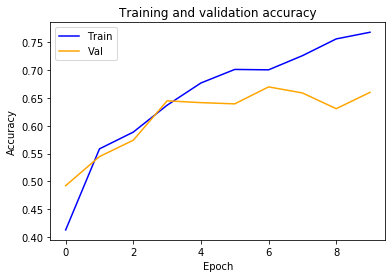

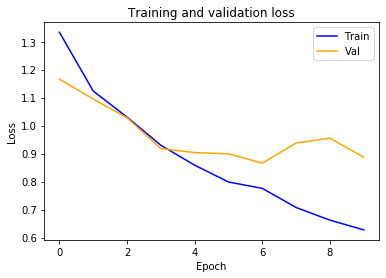

In [0]:
plot(history)

## 1c) Practice deploying your flowers classifier using TensorFlow.js
In the final part of the assignment, you'll export the model you build to recognize landmarks on Columbia's campus, and get it working in the browser. If you're new to JavaScript (as most of us are), the mechanics will be difficult at first. 

Let's practice by exporting your flowers classifier, and getting it working with TensorFlow.js (the starter code provided is written to work with flowers model).

### Save your model

In [0]:
#model.save("/content/my_model.h5")

### Download your saved model to your local machine

In [0]:
#from google.colab import files
#files.download("/content/my_model.h5")

MessageError: ignored

### Visit notebook #2 (a2-2.ipynb on CourseWorks) to convert your saved model into to TensorFlow.js format

Follow the instructions there to prepare a webpage to run your flowers model in the browser. Once you have that working, you can continue with the rest of this assignment in this notebook.

## 1d) Classify flowers using transfer learning

In this part of the assignment, you'll use transfer learning to take advantage of a large pretrained model. It is not necesary to deploy this part in the browser.


Read this tutorial before completing this section:
* https://www.tensorflow.org/tutorials/images/transfer_learning

In [0]:
## TODO: your code here
# Choose a pretrained model, and import the application
# See https://keras.io/applications/ for a few choices
# When you import the model, you will want to remove the 
# final dense layer that performs classification (include_top=False)
# you will also want to import weights from ImageNet,
# and you will want to specify the input shape to match your images. 

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3)) # fix me. base_model = tf.keras.applications...

9412608/9406464 [==============================] - 1s 0us/step


In [0]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass
  
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [0]:
# do not update the pretrained weights during training
# (we won't use finetuning here)
base_model.trainable = False 

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [0]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train for 86 steps, validate for 29 steps
Epoch 1/5
86/86 [==============================] - 9s 100ms/step - loss: 0.9673 - accuracy: 0.6370 - val_loss: 1.0303 - val_accuracy: 0.6078
Epoch 2/5
86/86 [==============================] - 6s 69ms/step - loss: 0.4788 - accuracy: 0.8390 - val_loss: 0.7957 - val_accuracy: 0.6841
Epoch 3/5
86/86 [==============================] - 6s 69ms/step - loss: 0.3955 - accuracy: 0.8659 - val_loss: 0.7281 - val_accuracy: 0.7364
Epoch 4/5
86/86 [==============================] - 6s 69ms/step - loss: 0.3543 - accuracy: 0.8728 - val_loss: 0.7609 - val_accuracy: 0.7320
Epoch 5/5
86/86 [==============================] - 6s 68ms/step - loss: 0.3178 - accuracy: 0.8910 - val_loss: 0.7744 - val_accuracy: 0.7386


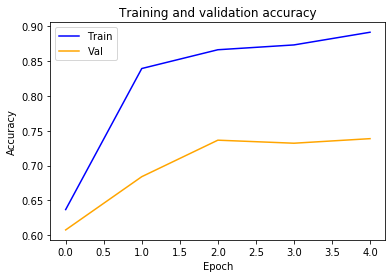

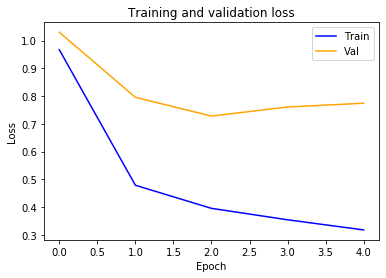

In [0]:
history = model.fit(train_ds, validation_data=test_ds, epochs=5)
plot(history)

## 2a) Recognize landmarks on Columbia's campus

In this part of the assignment, you will train a model to recognize landmarks (famous places, like the [Alma Mater sculpture](https://en.wikipedia.org/wiki/Alma_Mater_(New_York_sculpture), or Butler library) on Columbia’s campus. Instead of tf.data, you will gain experience with the higher level Keras utilties. You will also experiment with data augmentation to increase the effective size of your dataset.

Starter code is not provided for this part of the assignment. You should base your work off the following Keras notebook, which works identically in TF2 (the only thing you'll need to change is the imports, an example of correct imports is given below).

* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb

Here are steps you should complete.

1. Collect a dataset of at least three landmarks. Your dataset should include at least 50 images of each landmark in train, and 50 in validation (using more images is fine). Randomly shuffle your data to create these splits. You do not need to use a separate test set in this assignment.

 You will need to upload your dataset to Colab in order to train a model. To do so, you can either upload it using the file browser (slow and tedious, you'll need to repeat that if your runtime is reset), or (better) you can upload your dataset to Google Drive, then mount your drive as a filesystem in Colab (View -> Table of contents -> Code snippets -> search for "drive"). This will enable you to access the contents of your drive with commands like `!ls /gdrive`. As a another option, you could upload your dataset to a cloud provider or your Columbia account, then download it similarly to flowers at the top of this notebook.
 
1. Write a model to classify your data. Try to train a small model in terms of the number of parameters (you do not need to use transfer learning). 

1. Show predictions on several images.

1. Use data augmentation, see if this helps to improve accuracy.

1. Produce plots of accuracy / loss as a function of epochs. Determine the right place to stop training without overfitting.

When you have a reasonably accurate model, proceed to the next step. There are no guidelines for accuracy, try to build something you feel works well, given the small amount of data you have.

### 2a) 1. Collect a dataset and split it

We have 7 landmarks alma, butler, fontain (in front of alma), lion (at dodge),posseidon (where?), thing (don't know the real name), uris (sculpture in front of it)





In [0]:
# I splited the data using split_folders
# Usefull for the data augmentation part instead of using the split in the ImageDataGenerator
# split_folders.ratio('photos', output="output", seed=1337, ratio=(.5, .5))
import numpy as np

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Example code showing the correct imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

data_root_orig_train = '/gdrive/My Drive/mixed_data_split/train'
data_root_orig_val = '/gdrive/My Drive/mixed_data_split/val'
data_root_train = pathlib.Path(data_root_orig_train)
data_root_val = pathlib.Path(data_root_orig_val)
# Example code:
# You should use the keras preprocessing utilities here instead of tf.data
# Here's an example of how to use them with the flowers dataset
# You will need to add data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)#, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    data_root_train,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = "sparse"
    #subset='training'
    )

val_generator = train_datagen.flow_from_directory(
    data_root_val,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = "sparse"
    )

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

for data_batch, labels_batch in val_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
###
# TODO: your code for 2a here.
###

Found 1234 images belonging to 7 classes.
Found 1238 images belonging to 7 classes.
data batch shape: (32, 192, 192, 3)
labels batch shape: (32,)
data batch shape: (32, 192, 192, 3)
labels batch shape: (32,)


In [0]:
data_classes = train_generator.classes
N = len(data_classes)
class_weight = dict()
for i in range(train_generator.num_classes):
  class_weight[i] = (((data_classes == i).sum())/N)

class_weight

{0: 0.07374392220421394,
 1: 0.10210696920583469,
 2: 0.1312803889789303,
 3: 0.14910858995137763,
 4: 0.10291734197730956,
 5: 0.2034035656401945,
 6: 0.23743922204213938}

In [0]:
img_final = train_generator[0][0][0]
print(img_final.shape)
print(img_final.min())
print(img_final.max())

(192, 192, 3)
0.0
1.0


In [0]:
num2name = dict()
keys = list(val_generator.class_indices.keys())
for i in range(len(keys)):
  name = keys[i]
  num2name[i] = name
num2name

{0: 'alma',
 1: 'butler',
 2: 'fontain',
 3: 'lion',
 4: 'posseidon',
 5: 'thing',
 6: 'uris'}

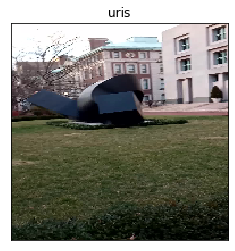

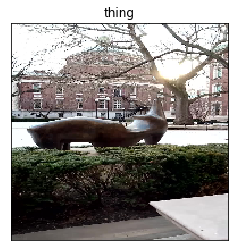

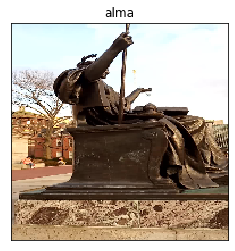

<Figure size 432x288 with 0 Axes>

In [0]:
x,y = len(train_generator), len(train_generator[i][1])
for n in range(3):
  i = random.randint(0,x-1)
  j = random.randint(0,y-1)
  image = train_generator[i][0][j]
  label = num2name[train_generator[i][1][j]]
  show(image, label)
  plt.figure()


### 2a) 2. a small CNN

During the training, I noticed that my validation data was too similar form my training data. Thus it's hard to tell if I'm overfitting or just have great accuracy.
I took a 2nd round of video, but still the results are the same, as the training and validation images are generally differents only by translations and bit of variation.

#### 787 nb of parameters 97% val acc / 94% with the new data set

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D(pool_size=(4,4)))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(4,4)))
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(4,4)))

model.add(layers.Flatten())
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 190, 190, 4)       112       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 47, 47, 4)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 4)         148       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 4)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 8)           296       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 2, 2, 8)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)               

In [0]:
history = model.fit(train_generator, epochs=20, validation_data=val_generator, class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 39 steps
Epoch 1/20
39/39 [==============================] - 56s 1s/step - loss: 0.2887 - accuracy: 0.2310 - val_loss: 0.2752 - val_accuracy: 0.2375
Epoch 2/20
39/39 [==============================] - 55s 1s/step - loss: 0.2720 - accuracy: 0.2399 - val_loss: 0.2657 - val_accuracy: 0.2431
Epoch 3/20
39/39 [==============================] - 55s 1s/step - loss: 0.2618 - accuracy: 0.2545 - val_loss: 0.2519 - val_accuracy: 0.2625
Epoch 4/20
39/39 [==============================] - 54s 1s/step - loss: 0.2426 - accuracy: 0.3476 - val_loss: 0.2247 - val_accuracy: 0.4136
Epoch 5/20
39/39 [==============================] - 54s 1s/step - loss: 0.2073 - accuracy: 0.4538 - val_loss: 0.1810 - val_accuracy: 0.5493
Epoch 6/20
39/39 [==============================] - 55s 1s/step - loss: 0.1555 - accuracy: 0.5940 - val_loss: 0.1316 - val_accuracy: 0.7076
Epoch 7/20
39/39 [==============================] - 55s 1s/step - lo

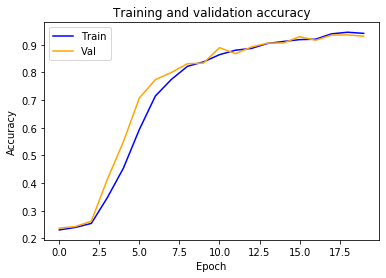

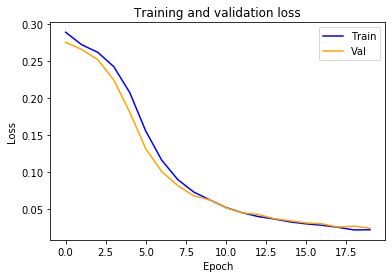

In [0]:
plot(history)

In [0]:
history2 = model.fit(train_generator, epochs=40, validation_data=val_generator, initial_epoch =  history.epoch[-1], class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 39 steps
Epoch 20/40
39/39 [==============================] - 54s 1s/step - loss: 0.0205 - accuracy: 0.9506 - val_loss: 0.0224 - val_accuracy: 0.9386
Epoch 21/40
39/39 [==============================] - 54s 1s/step - loss: 0.0203 - accuracy: 0.9538 - val_loss: 0.0282 - val_accuracy: 0.9362
Epoch 22/40
39/39 [==============================] - 54s 1s/step - loss: 0.0191 - accuracy: 0.9603 - val_loss: 0.0209 - val_accuracy: 0.9338
Epoch 23/40
39/39 [==============================] - 54s 1s/step - loss: 0.0158 - accuracy: 0.9652 - val_loss: 0.0201 - val_accuracy: 0.9451
Epoch 24/40
39/39 [==============================] - 54s 1s/step - loss: 0.0143 - accuracy: 0.9692 - val_loss: 0.0167 - val_accuracy: 0.9588
Epoch 25/40
39/39 [==============================] - 54s 1s/step - loss: 0.0138 - accuracy: 0.9660 - val_loss: 0.0163 - val_accuracy: 0.9620
Epoch 26/40
39/39 [==============================] - 54s 1s/st

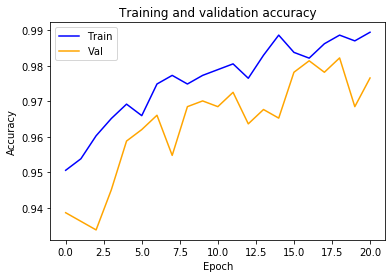

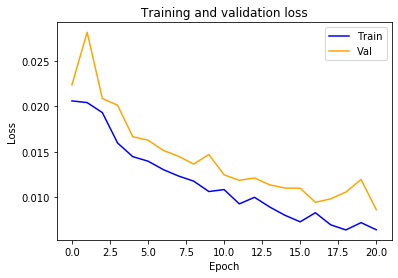

In [0]:
plot(history2)

#### 399 nb of parameters 86% / 90% with the new data set

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(3, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D(pool_size=(4,4)))
model.add(layers.Conv2D(3, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(4,4)))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(4,4)))

model.add(layers.Flatten())
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 190, 190, 3)       84        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 47, 47, 3)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 45, 45, 3)         84        
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 11, 11, 3)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 9, 9, 4)           112       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 2, 2, 4)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16)               

In [0]:
history = model.fit(train_generator, epochs=15, validation_data=val_generator, class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 39 steps
Epoch 1/15
39/39 [==============================] - 55s 1s/step - loss: 0.3022 - accuracy: 0.2374 - val_loss: 0.2958 - val_accuracy: 0.2375
Epoch 2/15
39/39 [==============================] - 54s 1s/step - loss: 0.2906 - accuracy: 0.2374 - val_loss: 0.2865 - val_accuracy: 0.2375
Epoch 3/15
39/39 [==============================] - 54s 1s/step - loss: 0.2813 - accuracy: 0.2374 - val_loss: 0.2762 - val_accuracy: 0.2375
Epoch 4/15
39/39 [==============================] - 54s 1s/step - loss: 0.2719 - accuracy: 0.2374 - val_loss: 0.2661 - val_accuracy: 0.2375
Epoch 5/15
39/39 [==============================] - 54s 1s/step - loss: 0.2591 - accuracy: 0.2439 - val_loss: 0.2519 - val_accuracy: 0.2811
Epoch 6/15
39/39 [==============================] - 54s 1s/step - loss: 0.2422 - accuracy: 0.2877 - val_loss: 0.2319 - val_accuracy: 0.3368
Epoch 7/15
39/39 [==============================] - 54s 1s/step - lo

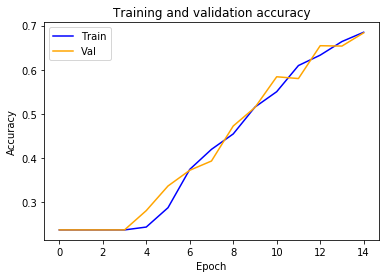

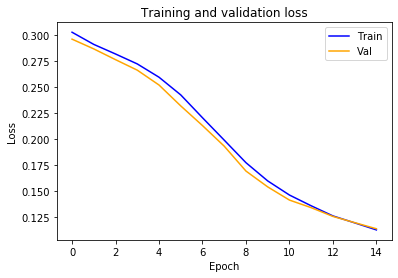

In [0]:
plot(history)

In [0]:
history2 = model.fit(train_generator, epochs=30, validation_data=val_generator, initial_epoch =  history.epoch[-1], class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 39 steps
Epoch 15/30
39/39 [==============================] - 55s 1s/step - loss: 0.1074 - accuracy: 0.7034 - val_loss: 0.1096 - val_accuracy: 0.7027
Epoch 16/30
39/39 [==============================] - 54s 1s/step - loss: 0.1041 - accuracy: 0.7123 - val_loss: 0.1059 - val_accuracy: 0.7173
Epoch 17/30
39/39 [==============================] - 55s 1s/step - loss: 0.0994 - accuracy: 0.7204 - val_loss: 0.1032 - val_accuracy: 0.6971
Epoch 18/30
39/39 [==============================] - 54s 1s/step - loss: 0.0954 - accuracy: 0.7326 - val_loss: 0.0993 - val_accuracy: 0.7116
Epoch 19/30
39/39 [==============================] - 54s 1s/step - loss: 0.0932 - accuracy: 0.7310 - val_loss: 0.0974 - val_accuracy: 0.7205
Epoch 20/30
39/39 [==============================] - 54s 1s/step - loss: 0.0904 - accuracy: 0.7496 - val_loss: 0.0969 - val_accuracy: 0.7036
Epoch 21/30
39/39 [==============================] - 54s 1s/st

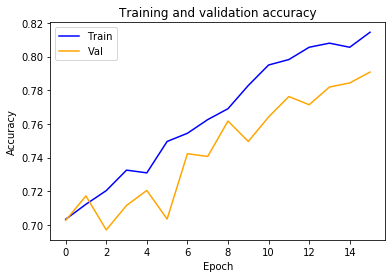

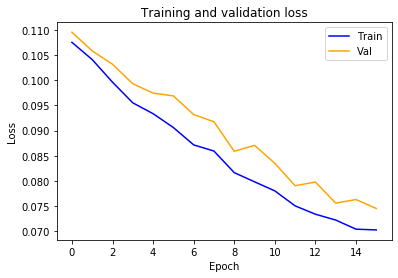

In [0]:
plot(history2)

In [0]:
history3 = model.fit(train_generator, epochs=45, validation_data=val_generator, initial_epoch =  history2.epoch[-1], class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 39 steps
Epoch 30/45
39/39 [==============================] - 55s 1s/step - loss: 0.0681 - accuracy: 0.8144 - val_loss: 0.0716 - val_accuracy: 0.7924
Epoch 31/45
39/39 [==============================] - 55s 1s/step - loss: 0.0656 - accuracy: 0.8241 - val_loss: 0.0717 - val_accuracy: 0.8005
Epoch 32/45
39/39 [==============================] - 54s 1s/step - loss: 0.0643 - accuracy: 0.8225 - val_loss: 0.0701 - val_accuracy: 0.8069
Epoch 33/45
39/39 [==============================] - 55s 1s/step - loss: 0.0638 - accuracy: 0.8314 - val_loss: 0.0684 - val_accuracy: 0.8053
Epoch 34/45
39/39 [==============================] - 54s 1s/step - loss: 0.0632 - accuracy: 0.8314 - val_loss: 0.0713 - val_accuracy: 0.8045
Epoch 35/45
39/39 [==============================] - 54s 1s/step - loss: 0.0615 - accuracy: 0.8355 - val_loss: 0.0672 - val_accuracy: 0.8126
Epoch 36/45
39/39 [==============================] - 54s 1s/st

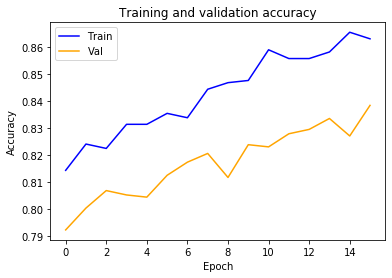

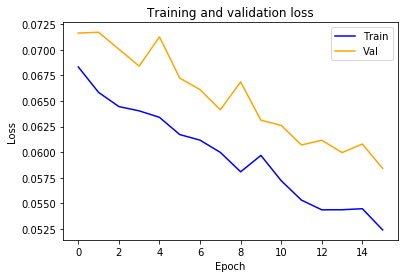

In [0]:
plot(history3)

### 2a) 3. Predictions

In [0]:
def confusion_matrix(val_generator):
  res = np.zeros((7,7))
  nb_label = np.zeros(7)

  for batch in range(len(val_generator)):
    for label in range(7):
      X_comprendre = val_generator[batch][0][val_generator[batch][1]==float(label)]
      nb_label[label] += len(X_comprendre)
      if len(X_comprendre)>0:
        Y_comprendre = model.predict(X_comprendre)
        predicted_comprendre = np.array([np.argmax(x) for x in Y_comprendre])
        for j in range(7):
          res[j,label] += np.sum(predicted_comprendre==j)
  error = (res/nb_label).T
  return error, res.T, nb_label

    

In [0]:
test_generator = train_datagen.flow_from_directory(
    data_root_train,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = "sparse",
    subset='validation'
    )

Found 247 images belonging to 7 classes.


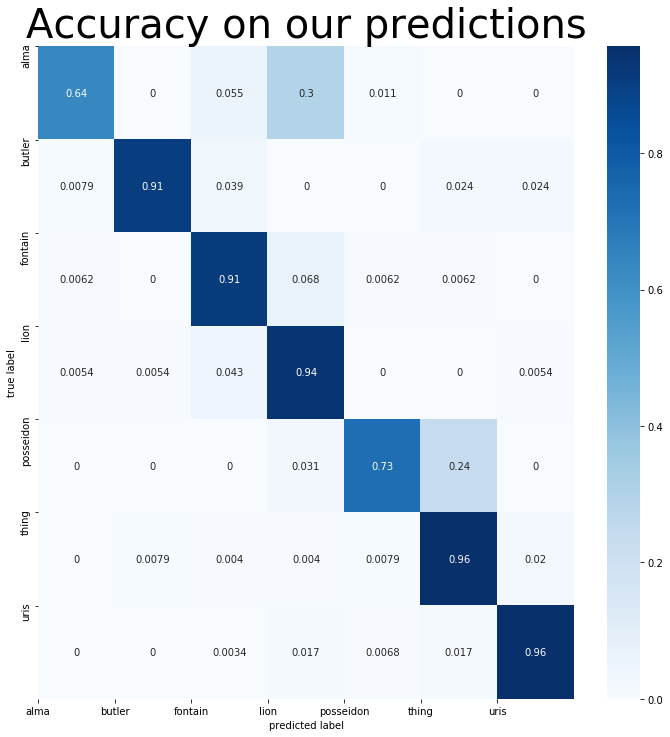

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
error = confusion_matrix(val_generator)[0]
legend_names = list(val_generator.class_indices.keys())
fig=plt.figure(figsize=(12,12))
sns.heatmap(error, cmap="Blues", annot=True)
plt.title('Accuracy on our predictions', fontsize = 40)
plt.ylabel('true label')
plt.xticks(np.arange(7), legend_names)
plt.yticks(np.arange(7), legend_names)
#plt.set_horizontalalignment('center')

plt.xlabel('predicted label')
plt.show()

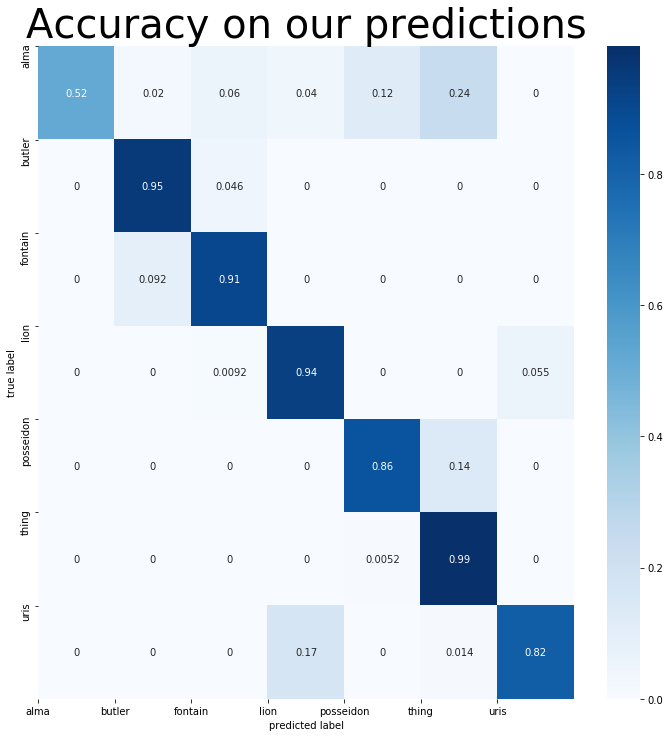

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
error = confusion_matrix(val_generator)[0]
legend_names = list(val_generator.class_indices.keys())
fig=plt.figure(figsize=(12,12))
sns.heatmap(error, cmap="Blues", annot=True)
plt.title('Accuracy on our predictions', fontsize = 40)
plt.ylabel('true label')
plt.xticks(np.arange(7), legend_names)
plt.yticks(np.arange(7), legend_names)
#plt.set_horizontalalignment('center')

plt.xlabel('predicted label')
plt.show()

In [0]:
image.shape

(192, 192, 3)

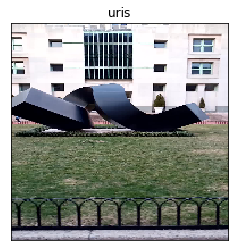

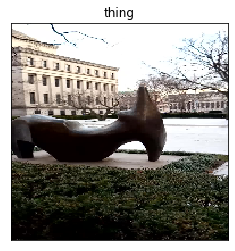

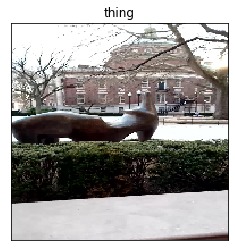

<Figure size 432x288 with 0 Axes>

In [0]:
x,y = len(val_generator), len(val_generator[i][1])
for n in range(3):
  i = random.randint(0,x-1)
  j = random.randint(0,y-1)
  image = val_generator[i][0][j]
  im_batch = tf.expand_dims(image, 0)
  label = num2name[np.argmax(model.predict(im_batch))]
  show(image, label)
  plt.figure()

plt.show()

### 2a) 4. Data Augmentation


The Data Augmentation might increase the generability of our algorithm.
Here we can't impove the validation accuracy as the training data was already too similar to the validation data.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

data_root_orig_train = '/gdrive/My Drive/mixed_data_split/train'
data_root_orig_val = '/gdrive/My Drive/mixed_data_split/val'
data_root_train = pathlib.Path(data_root_orig_train)
data_root_val = pathlib.Path(data_root_orig_val)
# Example code:
# You should use the keras preprocessing utilities here instead of tf.data
# Here's an example of how to use them with the flowers dataset
# You will need to add data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1./255, 
                                   validation_split= 0.5, 
                                   rotation_range=20,
                                   brightness_range = [0.5, 1.5],
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator_augmented = train_datagen_augmented.flow_from_directory(
    data_root_train,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = "sparse"
    )

val_generator_augmented = train_datagen.flow_from_directory(
    data_root_val,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = "sparse"
    )

Found 1234 images belonging to 7 classes.
Found 1238 images belonging to 7 classes.


#### 783 param 89%

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D(pool_size=(4,4)))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(4,4)))
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(4,4)))

model.add(layers.Flatten())
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 190, 190, 4)       112       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 47, 47, 4)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 45, 45, 4)         148       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 11, 11, 4)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 9, 9, 8)           296       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 2, 2, 8)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32)               

In [0]:
history = model.fit(train_generator_augmented, epochs=15, validation_data=val_generator_augmented)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 39 steps
Epoch 1/15
39/39 [==============================] - 68s 2s/step - loss: 1.9252 - accuracy: 0.1912 - val_loss: 1.8800 - val_accuracy: 0.2609
Epoch 2/15
39/39 [==============================] - 67s 2s/step - loss: 1.8731 - accuracy: 0.2658 - val_loss: 1.8512 - val_accuracy: 0.2302
Epoch 3/15
39/39 [==============================] - 66s 2s/step - loss: 1.8442 - accuracy: 0.2561 - val_loss: 1.8026 - val_accuracy: 0.2431
Epoch 4/15
39/39 [==============================] - 67s 2s/step - loss: 1.7871 - accuracy: 0.2528 - val_loss: 1.6951 - val_accuracy: 0.2593
Epoch 5/15
39/39 [==============================] - 67s 2s/step - loss: 1.6777 - accuracy: 0.3420 - val_loss: 1.5142 - val_accuracy: 0.3546
Epoch 6/15
39/39 [==============================] - 67s 2s/step - loss: 1.5118 - accuracy: 0.4036 - val_loss: 1.3095 - val_accuracy: 0.5016
Epoch 7/15
39/39 [==============================] - 66s 2s/step - lo

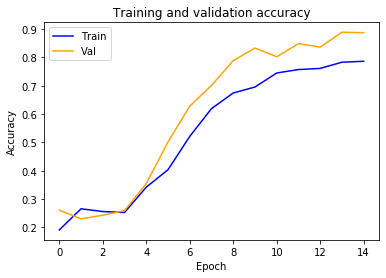

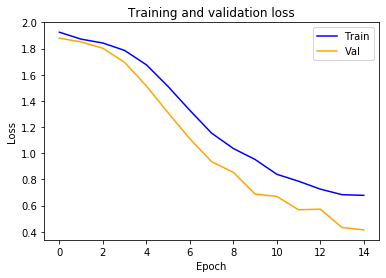

In [0]:
plot(history)

In [0]:
history2 = model.fit(train_generator_augmented, epochs=30, validation_data=val_generator_augmented, initial_epoch =  history.epoch[-1], class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 39 steps
Epoch 15/30
39/39 [==============================] - 68s 2s/step - loss: 0.0876 - accuracy: 0.7763 - val_loss: 0.0504 - val_accuracy: 0.8966
Epoch 16/30
39/39 [==============================] - 67s 2s/step - loss: 0.0803 - accuracy: 0.7877 - val_loss: 0.0500 - val_accuracy: 0.8877
Epoch 17/30
39/39 [==============================] - 67s 2s/step - loss: 0.0811 - accuracy: 0.7934 - val_loss: 0.0504 - val_accuracy: 0.8934
Epoch 18/30
39/39 [==============================] - 67s 2s/step - loss: 0.0802 - accuracy: 0.7885 - val_loss: 0.0503 - val_accuracy: 0.8837
Epoch 19/30
39/39 [==============================] - 67s 2s/step - loss: 0.0805 - accuracy: 0.7844 - val_loss: 0.0481 - val_accuracy: 0.8845
Epoch 20/30
39/39 [==============================] - 67s 2s/step - loss: 0.0816 - accuracy: 0.8031 - val_loss: 0.0475 - val_accuracy: 0.8829
Epoch 21/30
39/39 [==============================] - 67s 2s/st

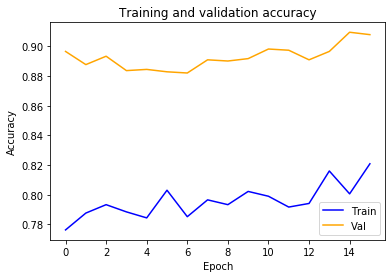

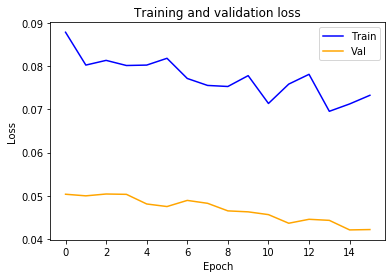

In [0]:
plot(history2)

#### 399 parameters 75% acc

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(3, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D(pool_size=(4,4)))
model.add(layers.Conv2D(3, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(4,4)))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(4,4)))

model.add(layers.Flatten())
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 190, 190, 3)       84        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 47, 47, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 45, 45, 3)         84        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 11, 11, 3)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 9, 4)           112       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 2, 2, 4)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 16)               

In [0]:
history = model.fit(train_generator_augmented, epochs=20, validation_data=val_generator_augmented)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 39 steps
Epoch 1/20
39/39 [==============================] - 68s 2s/step - loss: 1.9099 - accuracy: 0.2139 - val_loss: 1.8798 - val_accuracy: 0.1939
Epoch 2/20
39/39 [==============================] - 67s 2s/step - loss: 1.8672 - accuracy: 0.2147 - val_loss: 1.8657 - val_accuracy: 0.1785
Epoch 3/20
39/39 [==============================] - 67s 2s/step - loss: 1.8500 - accuracy: 0.2391 - val_loss: 1.8551 - val_accuracy: 0.2141
Epoch 4/20
39/39 [==============================] - 67s 2s/step - loss: 1.8516 - accuracy: 0.2220 - val_loss: 1.8369 - val_accuracy: 0.2520
Epoch 5/20
39/39 [==============================] - 67s 2s/step - loss: 1.8455 - accuracy: 0.2496 - val_loss: 1.8234 - val_accuracy: 0.2682
Epoch 6/20
39/39 [==============================] - 67s 2s/step - loss: 1.8330 - accuracy: 0.2626 - val_loss: 1.8103 - val_accuracy: 0.2763
Epoch 7/20
39/39 [==============================] - 67s 2s/step - lo

KeyboardInterrupt: ignored

In [0]:
plot(history)

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 16)          2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 16)          0

### 2)a 5. Plot history

In [0]:
model.save("/content/my_model.h5")
from google.colab import files
files.download("/content/my_model.h5")

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history2.history['accuracy']
val_acc += history2.history['val_accuracy']

loss += history3.history['loss']
val_loss += history3.history['val_loss']

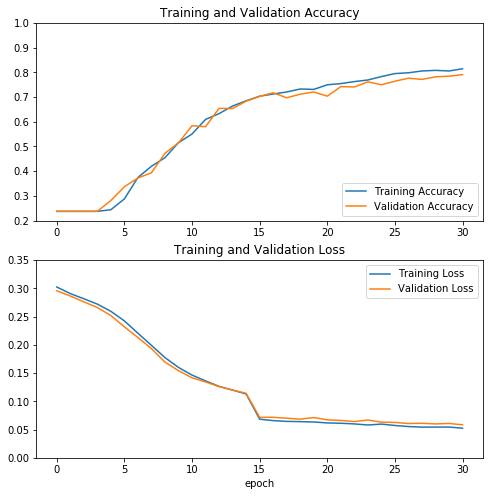

In [0]:
# from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.35])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


The right time to stop should be arround 25 afterward we do not overfit(remeber we "can't" overfit) as it improves a little with many epoch

## 2b) Run your model in the browser
Save and download your model, and head to notebook two again. After you've finished creating a webpage, upload it to GitHub Pages (or your Columbia account), list the URL here, save your assignment, and submit your assignment. You may not need to make many changes to the starter code, but pay attention to the preprocessing, number of output classes, image size, etc.

In [0]:
# TODO: list your URL here. 
# If you are unable to get it working in GitHub pages, you can also 
# submit a screenshot of your model running locally in a browser for
# partial credit.
# https://minssenp.github.io/